# Motivation

- What is your dataset?

- Why did you choose this/these particular dataset(s)?

- What was your goal for the end user's experience?

Overall our dataset consists of XXXX amount of theorists wikipedia pages, gathered from five wikipedia lists each representing a science with the overall theme of social science. By using the researchers references to each other we construct edges between the researchers, and therefore are able the map the overall science community of the social sciences. 

By looking into the researchers from each discipline we hope to find patterns in the connections both within the five categories but also between the five social sciences. We will first seek to answer the question of, what characteristics does the community of the five social sciences have? We will examine this question by looking into the over network properties of each followed by a network analysis. Thereafter we will examine the communities of the social sciences, by doing this we will answer these questions: Are the traditional categories within the social science community actually also apt/suitable for the social science community? Or are the categorizations just a historic relic which we should reject, and then embrace some other maybe more relevant categorizations within the social sciences? By looking into this it becomes possible to either deny or affirm the different scientists relevance within the different disciplines of the social science community. 

Our overall goal for the end user experience is to give a easy overview of the social sciences. We hope that our community detection models and our HSMB models maybe can give interested people a nuance in their view of the social sciences, instead of keeping to the old disciplines. By looking into our website interested researchers will maybe get inspiration to move out and beyond their own social science. 

# Basic

- Write about your choices in data cleaning and preprocessing

- Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

### Extracting data from wikipedias API

To construct this "community" of social scientists, we found inspiration by examining the department for Social Science at Copenhagen University. The Social Science department have five different sciences: Sociology, Psychology, Economy, Anthropology, and Political Science. For each of these five categories we have a list of scientists on wikipedia. We used these five lists of scientists to find and categorise all the scientists in our final dataset. After gathering all the names from the five lists, we then gather each individual scientists wikipage. Thus our data gathering process has two parts: 1) get social scientists from each of the five lists, 2) gather each scientists wikipage. 

If a scientist is mentioned on more than one list we calssiffy them as being in a sixth category 'Multiple'. 

Below we go more in depth with each of the two steps and our choices in the data cleaning process. 

#### Get social scientists from each of the five lists

Here we called the wiki API for each of the five list and then sorted the data. When cleaning the lists for theorists we used a regular expression to: XXXXXXXXXXXXXXXXX (ESBEN KOM OG FORKLAR) 

In [ ]:
####################################CALLING THE API for the five lists####################################################
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
import json

def get_wiki(_page, get_txt = False):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = f"titles={_page}"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    print(query)
    
    if get_txt == True:
        resp = requests.get(query).json()
        page_id = [i for i in resp['query']['pages'].keys()][0] # get page id
        txt = resp['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']
        return txt
    
    else:
        return requests.get(query).json()

resp_soc = get_wiki("List_of_sociologists")
resp_ant = get_wiki("List_of_anthropologists")
resp_pol = get_wiki("List_of_political_scientists")
resp_psy = get_wiki("List_of_psychologists")
resp_eco = get_wiki("List_of_economists")

In [ ]:
##################################Cleaning each social scientist discipline###################################
''' Soc '''
txt = resp_soc['query']['pages']['254243']['revisions'][0]['slots']['main']['*']
txt = txt.split('==A==')[1] # drop intro tekst
txt = txt.split('==References==')[0] # drop trailing stuff
sociologists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]*',txt)
print(f'Sociologists: {len(sociologists)}')

''' Ant '''
txt = resp_ant['query']['pages']['728']['revisions'][0]['slots']['main']['*']
txt = txt.split('==A==')[1] # drop intro tekst
txt = txt.split('==Fictional anthropologists==')[0] # drop trailing stuff
anthropologists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]*',txt)
print(f'Anthropologist: {len(anthropologists)}')

''' Eco '''
txt = resp_eco["query"]['pages']['10231']['revisions'][0]['slots']['main']['*']
txt = txt.split('==A==')[1] # drop intro tekst
txt = txt.split('==See also==')[0] # drop trailing stuff
economists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]*',txt)
print(f'economists: {len(economists)}')

''' Psy '''
txt = resp_psy['query']['pages']['199877']['revisions'][0]['slots']['main']['*']
txt = txt.split('== A ==')[1] # drop intro tekst
txt = txt.split('==See also==')[0] # drop trailing stuff
psychologists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]*',txt)
print(f'Psychologists: {len(psychologists)}')

''' Pol '''
txt = resp_pol['query']['pages']['37559']['revisions'][0]['slots']['main']['*']
txt = txt.split('== A ==')[1] # drop intro tekst
txt = txt.split('== See also ==')[0] # drop trailing stuff
political_scientists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]*',txt)
print(f'Political_scientists: {len(political_scientists)}')

# To dict
science_dict = {'soc':sociologists,
                'anth':anthropologists,
                'eco': economists,
                'psy': psychologists,
                'pol': political_scientists}

with open('science_name_dict.json', 'w', encoding = 'utf-8') as f:
    json.dump(science_dict,f)

### Gather each scientists wikipage

For gathering the theorists wikipages we use the "get_wiki" function, which we also used to gather the fives lists before. But when gathering XXXX amount of links instead of five it is also natural to meet some more problems. We both had the problem that some theorists pages redirected us to another page, which we need to call  

In [ ]:
import time
import copy

with open('science_name_dict.json', 'r', encoding = 'utf-8') as f:
    science_dict = json.load(f)

# Copy dict - deep copy as the values are nested in a list
new_science_dict = copy.deepcopy(science_dict)

    
''' Scrape the pages '''
for field, nodes in science_dict.items():
    for node in nodes:
        time.sleep(0.2)
        # Sometimes the pagelink refers to a site of a topic or a section of a larger wikipage. 
        # This we can spot by looking for a questionmark or hashtag.  
        if '#' in node or '?' in node: 
            new_science_dict[field].remove(node) # remove node 
            print('Skipping: ', node)
            continue
            
        node = node.replace(' ', '_')
        try:
            txt = get_wiki(node, get_txt = True)
            
            # Sometimes the page link we have gotten from one of our five lists is a "redirect"
            # Here it is nessecary to extract this new one. 
            if "#REDIRECT" in txt.upper(): # if it is a redirect
                new_science_dict[field].remove(node.replace('_', ' '))  # delete the old value 
                node = [re.findall('\[\[(.*?)(?:\|.*?)?\]\]', txt)[0]] # redirected link 
                print(f"## Redirect! {node}")
                new_science_dict[field] += node # append the new node (only element in a list) to the science_dict 
                node = node[0].replace(' ', '_') # extract from the list and replace 
                
                if '#' in node or '?' in node: 
                    new_science_dict[field].remove(node.replace('_', ' ')) # remove from dict
                    print('Skipping: ', node)
                    continue                    
                    
                txt = get_wiki(node, get_txt=True)
                
        except KeyError as e: # if the page is incomplete (red hyperlinks)
            new_science_dict[field].remove(node.replace('_', ' ')) # remove from dict 
            print(e, node)
            continue
        
        with open(f'wiki_content/{node}.txt', 'w', encoding = 'utf-8') as f:
            f.write(txt)
            
# Gem den opdaterede dict 
with open('science_name_dict.json', 'w', encoding = 'utf-8') as f:
    json.dump(new_science_dict,f)

### Parsing the data for constructing the network

Get the name of all the files from the wiki-scrape

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
from os import listdir
from os.path import isfile, join
import json 

# get files in directory 
onlyfiles = [f for f in listdir("wiki_content") if isfile(join("wiki_content", f))]

Make link list to construct a network

In [3]:
''' Extract links '''
theo_dict  = {}
for file in onlyfiles: # loop over the files 
    with open(f'wiki_content/{file}','r', encoding = 'utf-8') as f:
        txt = f.read() # read files 
        links = re.findall('\[\[(.*?)(?:\|.*?)?]]', txt) # find links
        name = file.split('.txt')[0].replace('_',' ') # get name of the scientist
        theo_dict.update({name:links}) # update dict with scientist:all_links

''' WHo links to who '''
# dict with scientist:link_to_other_scientists
# .replace('_', ' ') on names, because some names are weird like 'Anselm_Strauss'
link_dict = {theorist:[_name.replace('_', ' ') for _name in links \
                       if _name.replace('_', ' ') in theo_dict.keys()]\
                       for theorist, links in theo_dict.items()}

''' To Link list '''
# Convert to list of (node_a, node_b)-set
link_list = [(node_a, node_b) for node_a, nodes in link_dict.items() for node_b in nodes]

Convert the dictionary `science_dict` to a structure where scientists are keys, and their dicipline is the value. If a scientist appears in more than one of the lists from wikipedia, we categorize them as `multiple`. The new dictionary will be used a attributes in the network. 

In [4]:
''' Get science attribute '''
with open('science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    science_dict = json.load(f)
    
''' Get those that are in multiple scientific field lists '''

socs = set(science_dict['soc'])
anths = set(science_dict['anth'])
ecos = set(science_dict['eco'])
psys = set(science_dict['psy'])
pols = set(science_dict['pol'])

# See of they appear in multiple field lists
seen = []
repeated = []
for l in [socs, anths, ecos, psys, pols]:
    for i in l: # loop over de enkelte guys'n'gals
        if i in seen:
            repeated.append(i)
        else:
            seen.append(i)

''' Inverse the dict to {scientist:field}-structure '''
inv_science_dict = {name:science for science, names in science_dict.items() for name in names}
''' change the scientific field to "both" if they are both in more than one field list '''
inv_science_dict = {name:('multiple' if name in repeated else sci)\
                    for name, sci in inv_science_dict.items()}

# Match keys to link_dict --> when importing link_dict, 'Anselm_Strauss' becomes 'Anselm Strauss'
# but in the inv_science_dict he is 'Anselm_Strauss'. So it is a mess without it   
inv_science_dict = {key.replace('_', ' '):val for key, val in inv_science_dict.items()}

with open('inv_science_name_dict.json', 'w', encoding = 'utf-8') as f: 
    json.dump(inv_science_dict, f)

Construct the network

In [5]:
''' Make network '''
import networkx as nx
import netwulf as nw
G = nx.DiGraph()
G.add_nodes_from(link_dict.keys())
G.add_edges_from(link_list)
nx.set_node_attributes(G, inv_science_dict, name = 'group') # node attributes 

We plot the network using netwulf

In [6]:
''' Run first time network needs to be created Plot network.
Afterwards, just import the config/network files below'''

# network, config = nw.visualize(G, plot_in_cell_below=False)

' Run first time network needs to be created Plot network.\nAfterwards, just import the config/network files below'

In [7]:
''' load the network configurations '''
with open("network_configurations/big_network.json", 'r') as f:
    network = json.load(f)

with open("network_configurations/big_config.json", 'r') as f:
    config = json.load(f)

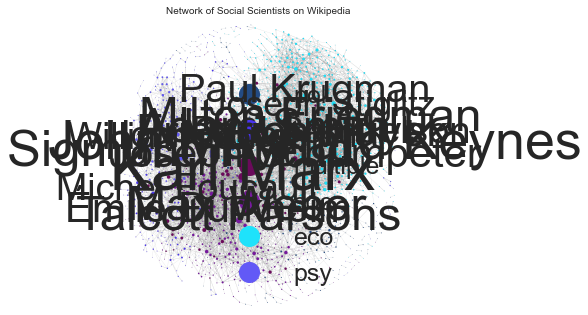

In [12]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')
#Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>7:
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*5)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {inv_science_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 20)

plt.legend(fontsize = 25)
ax.set_title('Network of Social Scientists on Wikipedia', size = 40)
# Saving as pdf
plt.savefig('Plots/field_network_title.png', dpi=None, facecolor='w', edgecolor='w', bbox_inches='tight')

Save the configuration for plotting the same network later, but with colors based on the community partition.

In [ ]:
''' Save the network configurations '''
with open("network_configurations/big_network.json", 'w') as f:
    json.dump(network, f)
    
with open("network_configurations/big_config.json", 'w') as f:
    json.dump(config, f)

### Descriptive statistics on the network

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

''' Function to plot Degree distribution '''
def plot_deg_dist(deg_seq, title = 'Degree distribution', save = False, save_title = "", kwgs = {}):
    plt.style.use('ggplot')
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[0], **kwgs)
    ax[0].set_title(title)
    ax[0].set_ylabel('Frequency', size = 15)
    
    del deg_seq[0] # messes up the log plot so remove 0 deg nodes 
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[1], **kwgs)

    ax[1].set_title(title + ' (log scaled)')
    ax[1].set_ylabel('Frequency', size = 15)
    ax[1].set_xlabel('k', size = 15)
    # logscale the axes
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    # Saving as pdf
    if save = True:
        plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

In [ ]:
''' Plot degree distribution '''
import seaborn as sns
from collections import Counter

# Get in and out degree
in_deg_dist = Counter([d for n,d in G.in_degree()])
out_deg_dist = Counter([d for n,d in G.out_degree()])

# Plot and save 
plot_deg_dist(in_deg_dist, 'In-degree Distribution', save=False, save_title="in_deg_dist")
plot_deg_dist(out_deg_dist, 'Out-degree Distribution', save=False, save_title= "out_deg_dist")

#### Plot the most connected nodes based on in- and out- degree

In [ ]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(top_n = 50, in_deg = True, save=False, save_title = ""):
    if in_deg:
        top_nodes = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    else:
        top_nodes = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    x = [_[0] for _ in top_nodes]
    y = [_[1] for _ in top_nodes]

    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(x,y, ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    if in_deg:
        ax.set_title(f'Distribution of in-degree for top {top_n}', size = 15)
    else:
        ax.set_title(f'Distribution of out-degree for top {top_n}', size = 15)
        
    # Saving as pdf
    if save = True:
        plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

In [ ]:
''' Call function '''
plot_top_nodes(in_deg = True, save_title="top_in_deg")
plot_top_nodes(in_deg = False, save_title="top_out_deg")

## Communities

Now that we have present some basic statistic of the network, we will will examine how and which communities are formed in the network based on the modularity optimization of the Louvain Partition.

In [ ]:
import community

''' Only the GCC, otherwise there will be about 300+ communities '''
G_c = G.copy()
c = max(nx.weakly_connected_components(G_c), key=len) # largest connected component
GCC = G_c.subgraph(c).copy() # make subgraph of the largest connected component
G_undir = GCC.to_undirected().copy() # undirected

# Louvain modularity for partition
partition = community.best_partition(G_undir, random_state = 280395)

Save the partition

In [ ]:
# Dict with name as key and field and community dicts as values 
joined_dict = {name:{'field':inv_science_dict[name], 'community':com}\
               for name, com in partition.items()}

with open('name_field_community.json', 'w', encoding = 'utf-8') as f: 
    json.dump(joined_dict, f)

In [ ]:
''' Plot community partition '''
nx.set_node_attributes(G_undir, partition, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {partition[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label='Community {}'.format(v), 
                marker='o',
                linestyle="None")
# Place legend
plt.legend(bbox_to_anchor = (1,0.8))
# Saving as pdf
fig.savefig(f'Plots/community_network.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

#### Parsing the data for text analysis

# Tools, theory and analysis. Describe the process of theory to insight

- Talk about how you've worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

- How did you use the tools to understand your dataset?

#### ANALYSE STRUKTUR: 
Explain the overall idea

- Analysis step 1
    - explain what you're interested in
    - explain the tool
    - apply the tool
    - discuss the outcome

- Analysis step 2
    - explain what you're interested in
    - explain the tool
    - apply the tool
    - discuss the outcome

- Analysis step 3,
... and so on until the analysis is done

# Discussion. Think critically about your creation

- What went well?,
- What is still missing? What could be improved?, Why?

# Constributions

- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).

- It is not OK simply to write "All group members contributed equally".